In [127]:
import json
import random
from tqdm import tqdm
import requests
import os
import datetime
import time
import collections
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
def get_sdk_data(out_file):

    spath = '/data/home/wangyuliang/work/samples_requests/samples/forsms_samples.txt'
    url = 'http://service-oceanus.apps.intra.yongqianbao.com/get_device_snapshot_by_identity/'
    ##'http://service.oceanus.svc:8000/get_device_snapshot_by_identity/' if os.getenv('KUBERNETES_PORT_443_TCP_ADDR') else 
    with open(out_file, 'w') as out:
        with open(spath) as fd:
            for n, line in enumerate(fd):
                if n >= 1000:
                    break
                line = line.strip().split(',')
                cid = line[0]
                Id = line[1]
                label = line[-1]
                ctime = line[-2]
                params = {'identity_card_num': Id, 'search_type': 'sms'}
                st = datetime.datetime.strptime(ctime, "%Y-%m-%d %H:%M:%S") - datetime.timedelta(days=30)
                params['start_timestamp'] = str(int(time.mktime(st.timetuple())) * 1000 + int(st.microsecond / 1000) + 1)
                et = datetime.datetime.strptime(ctime, "%Y-%m-%d %H:%M:%S") + datetime.timedelta(minutes=15)
                params['end_timestamp'] = str(int(time.mktime(et.timetuple())) * 1000 + int(et.microsecond / 1000) + 1)
                data = requests.post(url, json=params, timeout=5).json()
                ret['result_dict'] = data['result_dict']
                ret['cid'] = cid
                ret['label'] = label
                out.write(json.dumps(ret)+'\n')

get_sdk_data('origin_data/origin_sms.txt')

In [9]:
with open('origin_data/test_sms.txt') as fd:
    notnull = 0
    more1 = 0
    dic = collections.defaultdict(int)
    for line in fd:
        data = json.loads(line)
        for it in data:
            if it not in ['cid', 'label'] and data[it] != {}:
                notnull += 1
        keys = list(data.keys())
        keys.remove('cid')
        keys.remove('label')
        if len(keys) > 1:
            more1 += 1
            dic[len(keys)] += 1
print 'notnull', notnull
print 'more1', more1
print dic

notnull 643
more1 30
defaultdict(<type 'int'>, {2: 27, 3: 3})


In [86]:
with open('origin_data/test_sms.txt') as fd:
    less200 = 0
    smslen = []
    datelen = []
    for line in fd:
        ret = json.loads(line)
        data = ret['result_dict'] if 'result_dict' in ret else ret
        deviceid = data.keys()
        if 'cid' in deviceid: deviceid.remove('cid')
        if 'label' in deviceid: deviceid.remove('label')
        cnt = 0
        for did in deviceid:
            if data[did] != {}:
                diff = data[did]['Sms']['diff']
                snap = data[did]['Sms']['snapshot']
                mind = 0;maxd = 0
                smsdate = []
                for it in diff.values():
                    if it[1] != None:
                        for slist in it[1]:
                            tdic = slist[1]
                            if tdic['type'] == 2:
                                continue
                            smsdate.append(tdic['sending_time'])
                if snap == None:
                    continue
                for it in snap['data']:
                    if it['type'] == 2:
                        continue
                    smsdate.append(it['sending_time'])
                timestamps = sorted(smsdate, reverse=True)
                
                if timestamps and len(timestamps) >= 200:
                    cnt += 1
                    datelen.append((timestamps[0]-timestamps[199])/86400000.0)
                    if (timestamps[0]-timestamps[199])/86400000.0 < 4:
                        print ret['cid']
                        break

hc_53979fa0-1863-11e9-b2ee-00163e1020bd
hc_346eed22-186d-11e9-8f55-00163e1008da
hc_5ae724fe-186f-11e9-8c44-00163e10728e


In [24]:
print less200, len(smslen), len(datelen)
print sorted(smslen)[:10], sorted(smslen)[-10:]
print sorted(datelen)[:10], sorted(datelen)[-10:]

314 340764 601
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1059, 1267, 1368, 1369, 1420, 1420, 1470, 1556, 1613, 1772]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [1219, 1267, 1274, 1284, 1338, 1361, 1452, 1460, 2308, 3301]


In [19]:
datelen = [i/86400000 for i in datelen]

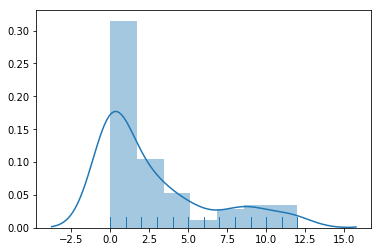

In [56]:
sns.distplot(datelen[:100], rug=True)

(array([  16384.,    8323.,    8224.,   44939.,  117714.,   59129.,
          16965.,   12946.,   12968.,   12408.]),
 array([   0. ,   13.3,   26.6,   39.9,   53.2,   66.5,   79.8,   93.1,
         106.4,  119.7,  133. ]),
 <a list of 10 Patch objects>)

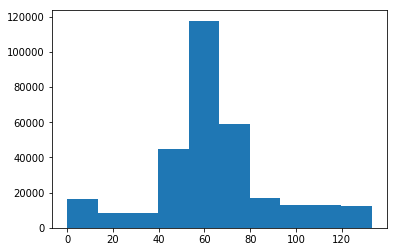

In [38]:
plt.hist(smslen[:310000])

In [27]:
smslen.sort()
datelen.sort()

In [80]:
len(datelen)

303

(array([ 275.,   19.,    4.,    0.,    0.,    1.,    1.,    1.,    0.,    2.]),
 array([    3.03192384,   140.02273419,   277.01354455,   414.0043549 ,
          550.99516525,   687.9859756 ,   824.97678595,   961.96759631,
         1098.95840666,  1235.94921701,  1372.94002736]),
 <a list of 10 Patch objects>)

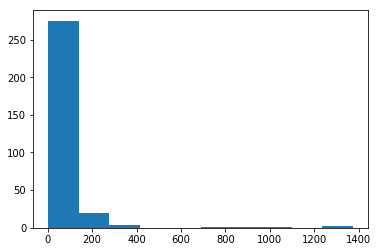

In [81]:
plt.hist(datelen)

## 生成训练集，验证集，测试集

In [126]:
try:
    tbar = tqdm(total=128313)
    fpath = 'origin_data/added_pos_sms.txt'
    train_out_path = 'origin_data/train_sms.txt'
#    vali_out_path = 'origin_data/vali_sms.txt'
#    test_out_path = 'origin_data/test_sms.txt'
    out_tr = open(train_out_path, 'a')
#    out_te = open(test_out_path, 'w')
#    out_va = open(vali_out_path, 'w')

    no_sms = 0
    len_less5 = 0
    day_less1 = 0
    sms_seqlen = {}
    sms_textlen = {}
    sms_timegap = {}
    with open(fpath) as fd:
        for line in fd:
            data = json.loads(line)
            ret = data['result_dict']
            sms_dict = {}
            for did in ret:
                if ret[did] == {}:
                    continue
                diff = ret[did]['Sms']['diff']
                snap = ret[did]['Sms']['snapshot']
                for ts in diff.values():
                    if ts[1] != None:
                        for slist in ts[1]:
                            it = slist[1]
                            if it['type'] == 2:
                                continue
                            sms_dict[it['sending_time']] = it['content']
                if snap == None:
                    continue
                for it in snap['data']:
                    if it['type'] == 2:
                        continue
                    sms_dict[it['sending_time']] = it['content']
            if sms_dict == {}:
                no_sms += 1
                continue
            keys = sorted(sms_dict.keys(), reverse=True)

            if len(keys) < 5:          ##  要求短信序列长度 > 5
                len_less5 += 1
                continue
            if keys[0] - keys[-1] < 86400000:       ##  要求序列时间跨度 > 1天
                day_less1 += 1
                continue
            cnt = 0
            filted_sms = {}
            sms_textlen[data['cid']] = []
            for k in keys:
                if cnt > 199: break
                text = sms_dict[k]
                if len(text) < 10:               ## 文本长度 > 10
                    continue
                filted_sms[k] = text[:128]       ##  文本长度  <=  128
                sms_textlen[data['cid']].append(len(filted_sms[k]))
                cnt += 1
            if len(filted_sms) < 5 or (keys[0] - keys[cnt-1]) / 86400000.0  > 365:      ##  要求短信序列长度 > 5 and 序列时间跨度 < 365天
                sms_textlen.pop(data['cid'])
                continue

            sms_seqlen[data['cid']] = cnt
            sms_timegap[data['cid']] = (keys[0] - keys[cnt-1]) / 86400000.0
            out_res = {'label': data['label'], 'cid': data['cid'], 'result_dict': filted_sms}
            out_tr.write(json.dumps(out_res)+'\n')
#            p = random.random()
#            if p < 0.05:
#                out_te.write(json.dumps(out_res)+'\n')
#            elif p < 0.1:
#                out_va.write(json.dumps(out_res)+'\n')
#            else:
#                out_tr.write(json.dumps(out_res)+'\n')
            tbar.update()
    tbar.close()
    out_tr.close()
#    out_te.close()
#    out_va.close()
except KeyboardInterrupt:
    tbar.close()
    raise

 27%|██▋       | 34430/128313 [04:37<12:36, 124.13it/s]


num of no sms data 49527
num of day less than 1 2095
num of length less than 5 3367
num of sms data 69475
total num of sms 2501100


(array([ 26629.,  15095.,   9683.,   6649.,   4171.,   2603.,   1811.,
          1163.,    941.,    730.]),
 array([  5.05115741e-04,   3.64966441e+01,   7.29927831e+01,
          1.09488922e+02,   1.45985061e+02,   1.82481200e+02,
          2.18977339e+02,   2.55473478e+02,   2.91969617e+02,
          3.28465756e+02,   3.64961895e+02]),
 <a list of 10 Patch objects>)

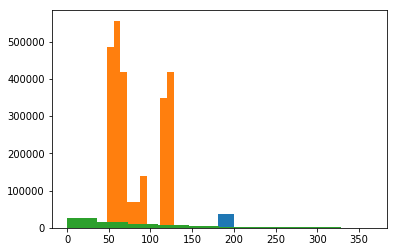

In [14]:
print 'num of no sms data', no_sms
print 'num of day less than 1', day_less1
print 'num of length less than 5', len_less5
print 'num of sms data', len(sms_seqlen)
plt.hist(sms_seqlen.values())
length = [x for x in it for it in sms_textlen.values()]
print 'total num of sms', len(length)
plt.hist(length)
plt.hist(sms_timegap.values())

(array([  9742.,   5847.,   4165.,   3032.,   2520.,   2077.,   1942.,
          1631.,   1499.,  37020.]),
 array([   5. ,   24.5,   44. ,   63.5,   83. ,  102.5,  122. ,  141.5,
         161. ,  180.5,  200. ]),
 <a list of 10 Patch objects>)

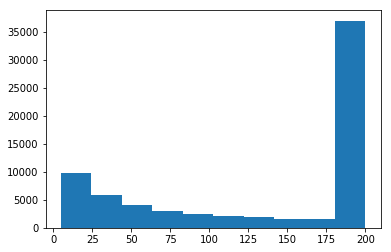

In [6]:
plt.hist(sms_seqlen.values())

2501100


(array([ 486325.,  555800.,  416850.,   69475.,   69475.,  138950.,
              0.,       0.,  347375.,  416850.]),
 array([  48.,   56.,   64.,   72.,   80.,   88.,   96.,  104.,  112.,
         120.,  128.]),
 <a list of 10 Patch objects>)

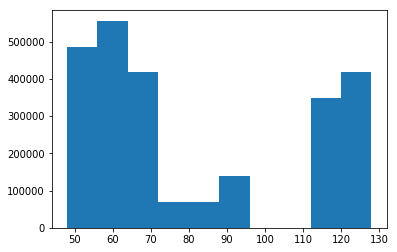

In [10]:
length = [x for x in it for it in sms_textlen.values()]
print len(length)
plt.hist(length)

(array([ 26629.,  15095.,   9683.,   6649.,   4171.,   2603.,   1811.,
          1163.,    941.,    730.]),
 array([  5.05115741e-04,   3.64966441e+01,   7.29927831e+01,
          1.09488922e+02,   1.45985061e+02,   1.82481200e+02,
          2.18977339e+02,   2.55473478e+02,   2.91969617e+02,
          3.28465756e+02,   3.64961895e+02]),
 <a list of 10 Patch objects>)

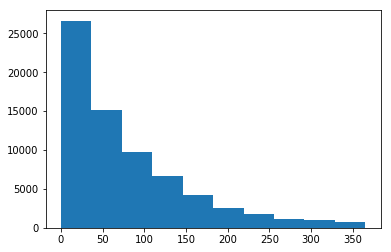

In [11]:
plt.hist(sms_timegap.values())

   ## 生成句向量，训练LSTM

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torch import optim
from bert_serving.client import BertClient
from sklearn.metrics import roc_auc_score
import numpy as np
import pdb

In [125]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.linear = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input, input_length, hidden):
        packed = nn.utils.rnn.pack_padded_sequence(input, input_length)
        output, (hidden, cell) = self.lstm(packed, hidden)
        hidden = torch.cat((hidden[0], hidden[1]), dim=1)
        output, output_length = nn.utils.rnn.pad_packed_sequence(output)
        output = self.sigmoid(self.linear(hidden))
        return output, hidden
    
    def initHidden(self):
        return (torch.zeros(2, self.batch_size,self.hidden_size), torch.zeros(2, self.batch_size,self.hidden_size))

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input, input_length, hidden):
        packed = nn.utils.rnn.pack_padded_sequence(input, input_length)
        output, (hidden, cell) = self.lstm(packed, hidden)
        output, output_length = nn.utils.rnn.pad_packed_sequence(output)
        output = self.sigmoid(self.linear(hidden))
        return output, hidden
    
    def initHidden(self):
        return (torch.zeros(1, self.batch_size,self.hidden_size), torch.zeros(1, self.batch_size,self.hidden_size))
    
def _read_file(fpath):
    with open(fpath) as fd:
        for line in fd:
            yield line
                
def load_data(reader, bc, batch_size=8):
    input_length = []
    input_text = []
    target = []
    for i in range(batch_size):
        try:
            data = json.loads(reader.next())
        except StopIteration:
            break
        ret = data['result_dict']
        keys = sorted(ret.keys())       ##  文本按照时间排序，正序
        sample = []
        for k in keys:
            if ret[k].strip() == '':
                continue
            sample.append(ret[k])
        #input_text.append([len(sample[-50:]), sample[-50:], data['label']])        ##  序列长度为200时训练不work，尝试长度变为50
        input_text.append([len(sample), sample, data['label']])        

    input_text.sort(key=lambda x: x[0], reverse=True)      ##  padding按长度排序，
    input_length = [x[0] for x in input_text]
    target = torch.tensor([int(x[2]) for x in input_text]).float().unsqueeze(1)
    input_text = [x[1] for x in input_text]
    input_vec = [get_vector(text_list, bc) for text_list in input_text]
    input_vec = [vector_padding(vec_array) for vec_array in input_vec]
    #input_tensor = torch.from_numpy(np.array(input_vec))
    #input_tensor = input_tensor.transpose(0,1).float()
    input_tensor = torch.from_numpy(input_vec[0]).float()        ##  （200， 130， 768） for  textcnn
    return input_tensor, input_length, target

def get_vector(text_list, bertclient):
    vec_array = bertclient.encode(text_list)
    return vec_array[:, 1:-1, :]

def vector_padding(input_vec):
    length = 200 - input_vec.shape[0]
    #length = 50 - input_vec.shape[0]
    #input_vec = np.concatenate((input_vec,np.zeros((length, 768))))
    input_vec = np.concatenate((input_vec,np.zeros((length, 128, 768))))        ## padding 词向量
    return input_vec

INPUT_SIZE = 768
HIDDEN_SIZE = 256
BATCH_SIZE = 1
TOTAL_NUM = 96955
OUT_CHANNEL = 100
KERNEL_SIZE = [2, 3, 5]
IS_VALI = False

def validation(model, criterion, bc):
    fpath = 'origin_data/vali_sms.txt'
    vbatch = 128
    reader = _reader(fpath)
    with torch.no_grade:
        input_tensor, input_length, target_tensor = load_data(reader, bc, vbatch)
        hidden = (torch.zeros(1, vbatch, HIDDEN_SIZE), torch.zeros(1, vbatch, HIDDEN_SIZE))
        output, hidden = model.forward(input_tensor, input_length, hidden)
        loss = criterion(output, target_tensor)
        auc = roc_auc_score(output.numpy(), target_tensor.numpy())
        return loss, auc

def trainIter(n_iters, print_every=1, lr=0.001, mode='lstm'):
    print_loss = 0
    if mode == 'lstm':
        model = LSTM(INPUT_SIZE, HIDDEN_SIZE, BATCH_SIZE)
    elif mode == 'textcnn':
        model = TextCNN(INPUT_SIZE, OUT_CHANNEL, KERNEL_SIZE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8)
    criterion = nn.BCELoss()      ##  用于二分类的损失函数，需手动加sigmoid
    #criterion = nn.CrossEntropyLoss()
    bc = BertClient()
    reader = _read_file('origin_data/train_sms.txt')
    start = time.time()
    outputs = []
    targets = []
    writer = SummaryWriter('/data/home/wangyuliang/logs/tensorboardlogger/')
    
    for epoch in range(1, n_iters+1):
        for i in range(1, TOTAL_NUM/BATCH_SIZE+1):
            input_tensor, input_length, target_tensor = load_data(reader, bc, BATCH_SIZE)
            load_time = time.time() - start
            #loss, output = train(input_tensor, input_length, target_tensor, model, optimizer, criterion)
            loss, output = textCNN_train(input_tensor, target_tensor, model, optimizer, criterion)
            writer.add_scalar('train/textCNN_loss', loss, i)
            writer.flush()
            print_loss += loss
            outputs.extend(output.detach().numpy().tolist())
            targets.extend(target_tensor.numpy().tolist())
            auc = '--'
            if i % print_every == 0:
                loss_avg = print_loss / print_every
                #auc = roc_auc_score(np.array(targets), np.array(outputs))
                #print targets
                outputs = []
                targets = []
                print_loss = 0
                if IS_VALI:
                    vali_loss, vali_auc = validation(model, criterion, bc)
                    print '=====>epoch:', epoch, ' batch:', i, ' train loss:',loss_avg, ' train auc:', auc, ' val loss:', vali_loss, ' vali auc:', vali_auc, ' cost: %.2fs'% (time.time() - start)
                else:
                    print '=====>epoch:', epoch, ' batch:', i, ' loss:',loss_avg, ' auc:', auc, ' label:', target_tensor[0], ' cost: %.2fs'% (time.time()-start), ' load cost: %.2fs'% (load_time)
                start = time.time()
                
def train(input_tensor, input_length, labels, model, optimizer, criterion):
    hidden = model.initHidden()
    optimizer.zero_grad()
    output, hidden = model.forward(input_tensor, input_length, hidden)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    #return loss.item() / sum(input_length), output
    return loss.item(), output

In [126]:
trainIter(10, mode='textcnn')

=====>epoch: 1  batch: 1  loss: 0.695195734501  auc: --  label: tensor([0.])  cost: 136.83s  load cost: 136.62s
=====>epoch: 1  batch: 2  loss: 0.695922374725  auc: --  label: tensor([1.])  cost: 1.99s  load cost: 1.48s
=====>epoch: 1  batch: 3  loss: 0.779644370079  auc: --  label: tensor([1.])  cost: 85.62s  load cost: 85.25s
=====>epoch: 1  batch: 4  loss: 0.671369194984  auc: --  label: tensor([0.])  cost: 75.58s  load cost: 75.17s
=====>epoch: 1  batch: 5  loss: 0.69858032465  auc: --  label: tensor([0.])  cost: 76.11s  load cost: 75.70s
=====>epoch: 1  batch: 6  loss: 0.640041470528  auc: --  label: tensor([0.])  cost: 82.55s  load cost: 82.15s
=====>epoch: 1  batch: 7  loss: 0.705514550209  auc: --  label: tensor([1.])  cost: 78.89s  load cost: 78.34s
=====>epoch: 1  batch: 8  loss: 0.63067907095  auc: --  label: tensor([0.])  cost: 82.44s  load cost: 82.18s
=====>epoch: 1  batch: 9  loss: 0.783275127411  auc: --  label: tensor([1.])  cost: 65.33s  load cost: 64.94s
=====>epoch:

=====>epoch: 1  batch: 76  loss: 0.824197947979  auc: --  label: tensor([1.])  cost: 1.90s  load cost: 1.52s
=====>epoch: 1  batch: 77  loss: 0.556210041046  auc: --  label: tensor([0.])  cost: 61.80s  load cost: 61.60s
=====>epoch: 1  batch: 78  loss: 0.49983549118  auc: --  label: tensor([0.])  cost: 1.67s  load cost: 1.30s
=====>epoch: 1  batch: 79  loss: 0.859706044197  auc: --  label: tensor([1.])  cost: 78.03s  load cost: 77.66s
=====>epoch: 1  batch: 80  loss: 0.485785424709  auc: --  label: tensor([0.])  cost: 75.66s  load cost: 75.09s
=====>epoch: 1  batch: 81  loss: 0.517024993896  auc: --  label: tensor([0.])  cost: 80.09s  load cost: 79.56s
=====>epoch: 1  batch: 82  loss: 0.919762969017  auc: --  label: tensor([1.])  cost: 78.05s  load cost: 77.63s
=====>epoch: 1  batch: 83  loss: 0.922472178936  auc: --  label: tensor([1.])  cost: 51.73s  load cost: 51.35s
=====>epoch: 1  batch: 84  loss: 0.449674010277  auc: --  label: tensor([0.])  cost: 77.95s  load cost: 77.60s


KeyboardInterrupt: 

## textCNN

In [123]:
class TextCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, stride=1):
        super(TextCNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.step = stride
        self.conv1 = nn.Sequential(
                        nn.Conv1d(in_channels, 2, 3),
                        nn.ReLU()
                    )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(2, 3, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Dropout(0.5)
        )
        self.linear = nn.Linear(675, 1)
    
    def forward(self, input):
        input = self.conv1(input.transpose(1,2))
        input = self.conv2(input.transpose(0,1).unsqueeze(0))
        out = torch.sigmoid(self.linear(input))
        return out
    
def textCNN_train(input_tensor, labels, model, optimizer, criterion):
    optimizer.zero_grad()
    out = model.forward(input_tensor)
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), out